In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# from numba import jit

from utils import *


%load_ext autoreload
%autoreload 2


"Detection of periodic driving in nonautonomous difference equations"

# Load data

+ Can increase epsilon radius to recover information from a broader area
+ 

In [5]:
from sklearn.base import BaseEstimator, ClusterMixin

class RecurrenceClustering(BaseEstimator, ClusterMixin):
    """
    Cluster points in a set of time series using recurrence families
    
    Attributes:
        tolerance (float): The expected fraction of recurrence events in the time series
            This defaults to 1% of all timepoints. Increasing this parameter improves 
            noise robustness, at the expense of decreasing the detail with which the
            driver can be resolved
        noise (float): The amplitude of the noise used to blur the input data (for 
            regularization).
        make_embedding (bool): Perform a time delay embedding before computing the 
            distance matrix. If multivariate time series are passed, each channel is 
            treated as an independent time series. Otherwise, the time series are 
            assumed to already have been embedded.
        metric ("euclidean" or "dtw"): Not Implemented. The metric to use to compute the
            distance matrix
        time_exclude (int): The number of neighboring timepoints to exclude from the 
            neighborhood calculation

    To do:
        Alternative distance metrics; implicit embedding via DTW calculation
        Matrix profile for acceleration
        Subclass for time series motif detection?
    
    """
    
    def __init__(self, tolerance=0.01,
                 resolution=1.0, 
                 d_embed=3, 
                 noise=0.0, 
                 eps=0.025, 
                 random_state=None, 
                 make_embedding=True,
                 time_exclude=0
                ):
        
        self.tolerance = tolerance
        self.eps = eps
        self.resolution = resolution
        self.make_embedding = make_embedding
        self.d_embed = d_embed
        self.noise = noise
        self.random_state = random_state
        self.time_exclude = time_exclude
    

    def fit(self, 
            X, 
            objective="modularity", 
            weighted=False, 
            method="graspologic", 
            use_sparse=False
           ):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)        
        """
        np.random.seed(self.random_state)
        
        # X is a stack of time series; embed each one
        # separately
        if self.make_embedding:
            ## Flatten multidimensional series
            X = np.reshape(X, (X.shape[0], -1))
            X = standardize_ts(X)
            ## Time delay embedding
            X_embed = _embed(X, self.d_embed)
        else:
            X_embed = X.copy()
            
        ## Regularization
        X_embed += self.noise *  (np.random.random(X_embed.shape) - 0.5)
        
        all_dist_mat = np.sqrt(
            np.sum(
                (X_embed[..., None, :] - X_embed[:, None, ...])**2, 
                axis=-1
            )
        ).T
        all_dist_mat += (np.eye(all_dist_mat.shape[0]) * 1e16)[..., None]

        dist_mat_min = np.min(all_dist_mat, axis=-1)
        #weight_matrix = 1 / dist_mat_min
        
        eps = self.eps
        eps = np.percentile(np.ravel(dist_mat_min), 100 * self.tolerance)
        print(f"Selected threshold is {eps}")
        
        dist_mat_bin = np.copy(dist_mat_min < eps).astype(int)
        print(f"Distance matrix sparsity is is {sparsity(dist_mat_bin)}")
        
        if self.time_exclude > 0:
            mask_mat = np.ones_like(dist_mat_min)
            mask_mat = 1 - (np.triu(mask_mat, k=-self.time_exclude) 
                            * np.tril(mask_mat, k=self.time_exclude))
            dist_mat_bin *= mask_mat.astype(int)
            
        amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                        weighted=weighted,
                                        use_sparse=use_sparse)
        
        
        
#         self.neighbor_matrix = amat # dist_mat_bin
#         self.distance_matrix = dist_mat_min
#         self.data_matrix = X_embed
#         self.a_matrix = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
#                                                  weighted=weighted,
#                                                  use_sparse=use_sparse)
        
        
        
        
        
        
        indices, labels = _leiden(
            amat, 
            resolution=self.resolution,
            objective=objective,
            method=method
        )
        sort_inds = np.argsort(indices)
        indices, labels = indices[sort_inds], labels[sort_inds]
        reference_indices = np.arange(amat.shape[0])
        
#         missing_vals = np.setxor1d(reference_indices, indices)
#         unclassified_inds = arg_find(reference_indices, missing_vals)
        
        self.indices = np.copy(reference_indices)
        self.labels_ = -np.ones_like(self.indices)
        self.labels_[indices] = labels
        
#         print(indices.shape, labels.shape)
#         self.indices = indices
#         self.labels_ = labels
        self.has_unclassified = np.any(self.labels_ < 0)
        self.n_clusters = len(np.unique(self.labels_)) - self.has_unclassified
    
    def get_driving(self, X):
        """
        Return the best estimate of the driving signal, using a maximum variance 
        heuristic
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        DEV: switch to a heuristic that maximizes spacing
        """
        vals_recon = self._get_full_driving(X)
                
        # Select best cycle example using largest variance principle
        max_spread_inds = np.argmax(np.sum(np.var(vals_recon, axis=1), 
                                           axis=-1), axis=-1)
        
        vals_recon = vals_recon[np.arange(len(max_spread_inds)), 
                                      :, max_spread_inds]
        return vals_recon
        
    
    def _get_full_driving(self, X):
        """
        Return all possible estimates of the driving signal across system. Negative 
        indices are ignored
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        Returns:
            class_example (np.ndarray): An array of shape (B, T, Te, D), where B is 
                the index of an input dataset for reconstruction, T is the effective 
                time index of the reconstructed signal. Te indexes particular points on 
                the driver. Each value of Te corresponds to a particular driver 
                representation.
        
        """
        
        X = np.reshape(X, (X.shape[0], -1))
        X = standardize_ts(X) ## check this
        X_embed = _embed(X, self.d_embed)
        # (B, T, D)
    
        class_example = list()
        for label in np.unique(self.labels_):
            if label < 0: continue
            #class_example.append(X_embed[:, self.labels_==label, :][:, 0])
            class_example.append(X_embed[:, self.labels_==label, :])
        time_cap = min([item.shape[1] for item in class_example])
        class_example = [item[:, :time_cap] for item in class_example]
        class_example = np.array(class_example)
        class_example = np.moveaxis(class_example, (0,1,2), (1,0,2))
        
        return class_example

    def transform(self, X):
        """
        Creates an embedding of a dataset based on the labels list
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            
        """
        cycle_vals = self.get_driving(X)
        all_cycles = list()
        for i in range(cycle_vals.shape[0]):
            sel_inds = self.labels_[self.labels_ >= 0]
            all_cycles.append(cycle_vals[i][sel_inds])
        return np.array(all_cycles)

    def fit_transform(self, X, y=None):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            y (ignored) : Not used, present here for consistency with sklearn API
        """
        return self.fit(X).transform(X)
    

In [915]:
## Continuous-time data

def rossler(x, y, z, t, a, b, c):
    xdot = -y - z
    ydot = x + a * y
    zdot = b + z * (x - c)
    return xdot, ydot, zdot


def torus(x, y, z, t, a, n, r):
    xdot = (-a * n * np.sin(n * t)) * np.cos(t) - (r + a * np.cos(n * t)) * np.sin(
        t
    )
    ydot = (-a * n * np.sin(n * t)) * np.sin(t) + (r + a * np.cos(n * t)) * np.cos(
        t
    )
    zdot = a * n * np.cos(n * t)
    return xdot, ydot, zdot

def vanderpol(x, y, z, t, a, mu, w):
    ydot = mu * (1 - x ** 2) * y - x + a * np.sin(z)
    xdot = y
    zdot = w
    return xdot, ydot, zdot


class DrivenVanDerPol:
    """
    """

    def __init__(self, random_state=None):
        
        # driver properties
        self.ad = 0.5
        self.n = 5.3
        self.r = 1
        
        # response properties
#         self.ar = 1.2
#         self.mu = 8.53
#         self.w = 0.63
        self.rho = 28
        self.beta = 2.667
        self.sigma = 10
        
        self.n_drive = 3
        self.n_response = 3
        
        
        ## rossler
#         self.a
        
        
        np.random.seed(random_state)
        self.n_sys = 50
        self.rho = 28 * (1 + 0.6*(np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.3*(np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 0.3*(np.random.random(self.n_sys) - 0.5))
        
        

#     def rhs_driver(self, t, X):
#         """
#         Add a quadratic potential in order to attract towards origin
#         """
#         x, y, z = X
#         a, n, r = self.ad, self.n, self.r
#         xdot = (-a * n * np.sin(n * t)) * np.cos(t) - (r + a * np.cos(n * t)) * np.sin(
#             t
#         ) - x
#         ydot = (-a * n * np.sin(n * t)) * np.sin(t) + (r + a * np.cos(n * t)) * np.cos(
#             t
#         ) - y
#         zdot = a * n * np.cos(n * t) - z
#         return xdot, ydot, zdot


    def rhs_driver(self, t, X):
        """
        Simple periodic driver
        """
        x, y, z = X
        a, n, r = self.ad, self.n, self.r
        xdot = a * np.sin(t)
        ydot =  a * np.sin(t)
        zdot =  a * np.sin(t)
        return xdot, ydot, zdot


    # Rossler driving (aperiodic)
#     def rhs_driver(self, t, X):
#         x, y, z = X
#         a, b, c = self.a, self.b, self.c
#         xdot = -y - z
#         ydot = x + a * y
#         zdot = b + z * (x - c)
#         return xdot, ydot, zdot
    
#     def rhs_response(self, t, X):
#         ar, mu = self.ar, self.mu
#         xd, yd, zd = X[:self.n_drive]
#         x, y, z = X[self.n_drive:]
#         #ydot = mu * (1 - x ** 2) * y - x + ar * np.sin(z)
#         ydot = mu * (1 - x ** 2) * y - x + ar * xd
#         xdot = y
#         zdot = self.w
#         return xdot, ydot, zdot


    def rhs_response(self, t, X):
        xd, yd, zd = X[:self.n_drive]
        x, y, z = X[self.n_drive:]
        beta, rho, sigma = self.beta, self.rho, self.sigma
        xdot = sigma * (y - x) + self.ar * xd
        ydot = x * (rho - z) - y
        zdot = x * y - beta * z
        return xdot, ydot, zdot
    
    
#     def rhs_response_ensemble(self, t, X):
#         Xd = X[0]
#         x, y, z = Xr[::self.n_response], Xr[1::self.n_response], Xr[2::self.n_response]
#         self.rhs_response([Xd, x, y, z])
    
    
    def rhs_response_ensemble(self, t, X):
        
        Xd = X[:self.n_drive]
        Xr = X[self.n_drive:]
        #n_sys = len(np.asarray(sigma))
        
        xd, yd, zd = Xd
        x, y, z = Xr[:self.n_sys], Xr[self.n_sys:2*self.n_sys], Xr[2*self.n_sys:]

        xdot = self.sigma * (y - x) + self.ar * xd
        ydot = x * (self.rho - z) - y
        zdot = x * y - self.beta * z
        return np.hstack([xdot, ydot, zdot])
    
    def rhs(self, t, X):
        return [*self.rhs_driver(t, X[:self.n_drive]), *self.rhs_response_ensemble(t, X)]
    
eq = DrivenVanDerPol()
eq.ar = 6

from scipy.integrate import solve_ivp
# ic = [-1.4311456845e+00, -2.5294548367e+00,  1.9465770285e-01] + [-1.9778877423e+00,  2.4192328851e-02, 1.2600000000e+02] 
# tpts0 = np.linspace(0, 200, 6000)
# tpts0 = np.linspace(0, 100, 3000)
# sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

ic = np.random.random(3 + 3*eq.n_sys)
tpts0 = np.linspace(0, 100, 3000)
sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

sol = sol0.y.T

transient_frac = 0.2
transient_n = int(transient_frac * len(sol))
sol = sol[transient_n:]
tpts = tpts0[:-transient_n]


sol_drive = sol[:, :3]
sol_response = sol[:, 3:]


# for ensemble
sol_response = np.moveaxis(
    np.reshape(
        sol_response,
        (sol_response.shape[0], eq.n_sys, -1),
        order="F"
    ),
    (0, 1, 2), (1, 0, 2)
)

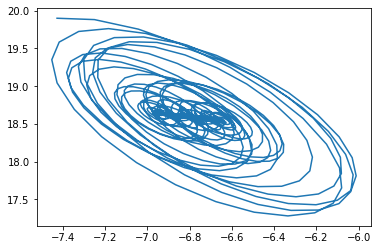

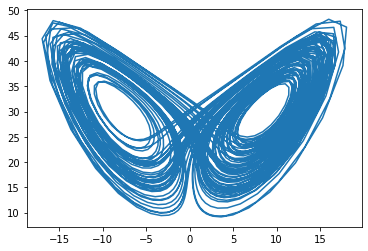

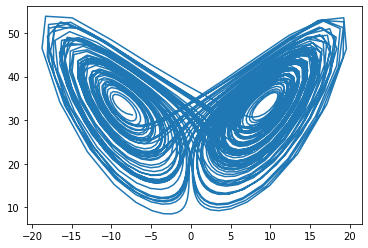

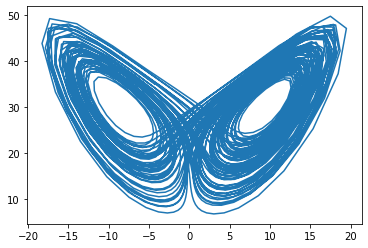

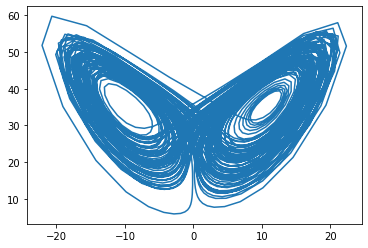

In [916]:
for i in range(5):
    plt.figure()
    plt.plot(sol_response[i, :, 0], sol_response[i, :, 2])

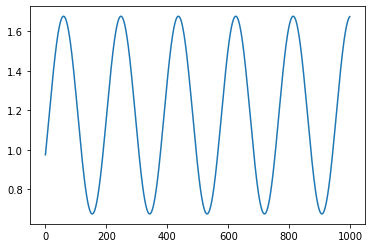

In [920]:
plt.plot(sol_drive[:1000, 0].T)

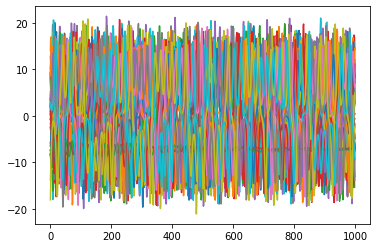

In [918]:
plt.plot(sol_response[:, :1000, 0].T);

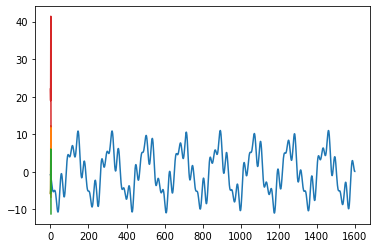

In [845]:
plt.plot(10*sol_drive[:1600, 0])
# plt.plot(np.sin(eq.w * tpts[:400]))
plt.plot(sol_response[:1600, 0])

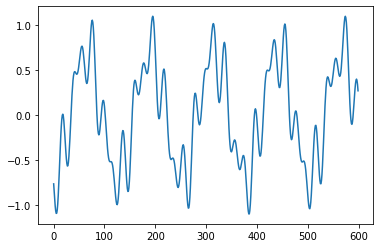

In [ ]:
plt.plot(sol_drive[:600, -3])

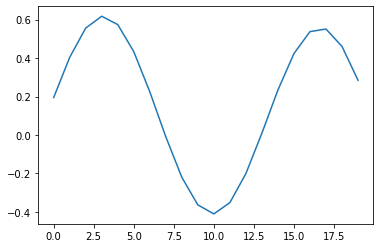

In [ ]:
plt.plot(sol0.y[2][:20])

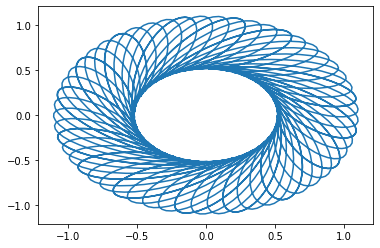

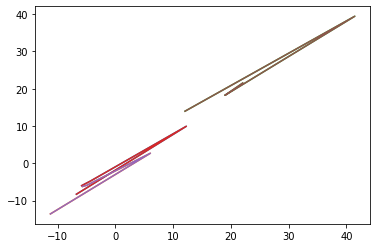

In [846]:
plt.figure()
plt.plot(sol_drive[:, -3], sol_drive[:, -2])

plt.figure()
plt.plot(sol_response[:, 0], sol_response[:, 1])
plt.plot(sol_response[:200, 0], sol_response[:200, 1])

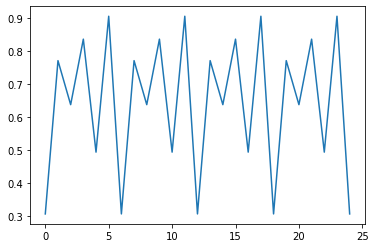

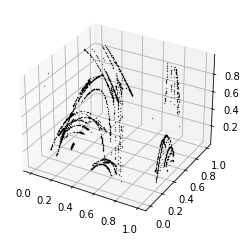

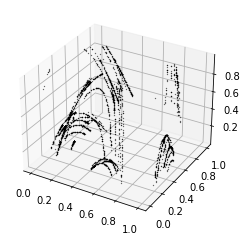

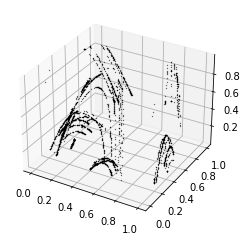

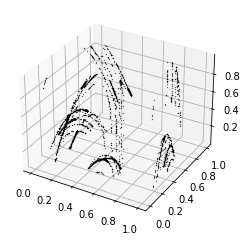

In [6]:


# def xn(x, d, lam=np.array([3.77, 3.775, 3.78, 3.785, 3.795])):
#     return np.mod((lam * x * (1 - x) + 0.5 * d), 1.0)

# def valnext(x, d, lam0=3.6266):
#     dn_val = lam0 * d * (1 - d)
#     xn_val = xn(x, d)
#     return xn_val, dn_val
np.random.seed(0)
curr = (np.random.random(5), 0.5)


def xn(x, d, lam=np.array([3.81, 3.82, 3.83, 3.84+.04])):
    return np.mod((lam * x * (1 - x) + 0.45 * d), 1.0)
            
# def valnext(x, d, lam0=3.835):
def valnext(x, d, lam0=3.6266):
    dn_val = lam0 * d * (1 - d)
    xn_val = xn(x, d)
    return xn_val, dn_val
np.random.seed(0)
curr = (np.random.random(4), 0.5)



# def xn(x, d, a1=3.2, b1=0.1, a2=0.1, b2=0.1):
#     x1n = a1 * x[0] * (1 - x[0]) + b1
#     x2n = np.mod(a2 * np.sin(6 * np.pi * x[1]) + x[1] + 1/3+ b2 * x[0], 1)
#     return np.array([x1n, x2n])

# def valnext(x, d, w=0.06*2*np.pi):
#     dn_val = np.mod(x + w, 1)
#     xn_val = xn(x, d)
#     return xn_val, dn_val
# np.random.seed(0)
# curr = (0.1*np.random.random(2), 0.5)

vals = [curr]
for i in range(3200):
    curr = valnext(*curr)
    vals.append(curr)
# vals = np.array(vals)[200:]
vals_drive = np.array([item[1] for item in vals])[200:]
vals_response = np.array([item[0] for item in vals])[200:, :]

## Make reconstructions with m = 3
m = 3
all_attractors = list()
for row in vals_response.T:
    embedding = list()
    for i in range(m):
        embedding.append(row[i : i - m])
    embedding = np.vstack(embedding).T
    all_attractors.append(embedding)
all_attractors = np.array(all_attractors)

## Plot attractors

plt.figure()
plt.plot(vals_drive[-25:])

for attractor in all_attractors:
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(attractor[:, 0], attractor[:, 1], attractor[:, 2], '.k', markersize=0.5)


In [ ]:
## How should the search radius scale withe error? There is clearly a tradeoff here
## More error --> more false neighbors

In [7]:
# eps = 0.005
# eps = 0.005 * 10 * 2 * 2
# eps = 0.005 * 10 * 2

eps = 0.005 * 5
# eps = 0.005



reference_attractor = np.copy(all_attractors[0])

guide_attractor_set = np.copy(all_attractors[1:]) # the one used to detect recurrences
guide_attractor_set = np.copy(all_attractors)

# all_all_points = list()
# all_dist_mat_bin = list()

guide_attractor_set_noise = guide_attractor_set + 0.02 * 5 * 3 * (np.random.random(guide_attractor_set.shape) - 0.5)
        
all_dist_mat = np.sqrt(
    np.sum(
        (guide_attractor_set[..., None, :] - guide_attractor_set[:, None, ...])**2, 
        axis=-1
    )
).T
all_dist_mat += (np.eye(all_dist_mat.shape[0]) * 1e16)[..., None]
pp1 = np.copy(all_dist_mat)

# all_dist_mat = list()
# for guide_attractor in guide_attractor_set:
    
#     # corruption
# #     guide_attractor += 0.02 * 5 * 3 * 2 * (np.random.random(guide_attractor.shape) - 0.5)
#     guide_attractor += 0 * 0.02 * 5 * 3 * (np.random.random(guide_attractor.shape) - 0.5)
        
#     dist_mat = np.sqrt(
#         np.sum(
#             (guide_attractor[None, ...] - guide_attractor[:, None, :])**2, 
#             axis=-1
#         )
#     )
    
#     dist_mat += (np.eye(dist_mat.shape[0]) * 1e16) ## Exclude self
#     all_dist_mat.append(np.copy(dist_mat))
# all_dist_mat = np.dstack(all_dist_mat)
# pp2 = np.copy(all_dist_mat)

dist_mat_min = np.min(all_dist_mat, axis=-1)
weight_matrix = 1/dist_mat_min
dist_mat_bin = np.copy(dist_mat_min < eps).astype(int)
    
all_merged_inds = list()
for row in dist_mat_bin:
    all_merged_inds.append(np.sort(np.where(row)[0]))

In [ ]:
neighbors ~ eps^3

noise ~ neighbors ?
noise ~ eps

array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])

In [235]:
k_neighbors = 5
volume_eps = (4/3) * np.pi * eps**3
local_dist = np.mean(np.sort(dist_mat_min, axis=0)[:k_neighbors])
point_density = k_neighbors / (4/3) * np.pi * local_dist**3
expected_neighbors = point_density * volume_eps

In [234]:
noise_distance = 0.1
volume_noise = (4/3) * np.pi * noise_distance**3


0.03715835938420876

In [20]:
# 
eps_vals = np.logspace(-5, -1, 10)
nu_vals = np.logspace(-5, 0, 30)
#eps = 0.001

start_vals = list()
end_vals = list()

turn_vals = list()

all_tolerance_vals = list()

for eps in eps_vals:

    fraction_neighbors = list()
    tolerance_vals = list()
    for nu_val in nu_vals:
        guide_attractor = np.copy(all_attractors[-1]) 
        guide_attractor += nu_val * (np.random.random(guide_attractor.shape) - 0.5)

        dist_mat = np.sqrt(
            np.sum(
                (guide_attractor[None, ...] - guide_attractor[:, None, :])**2, 
                axis=-1
            )
        )
        dist_mat_bin = np.copy(dist_mat < eps).astype(int)
        frac_n = np.sum(dist_mat_bin) / float(dist_mat_bin.size)
        fraction_neighbors.append(frac_n)
        
        #tolerance_vals.append(np.sqrt(np.median((np.diff(guide_attractor, axis=0))**2)))
        #tolerance_vals.append(np.mean(np.abs((np.diff(guide_attractor, axis=0))**2)))
        #tolerance_vals.append(np.sqrt(np.mean((np.diff(guide_attractor, axis=0))**2)))
        #tolerance_vals.append(np.mean(dist_mat**2))
        #tolerance_vals.append(np.std(np.diff(guide_attractor, axis=0)))
        
        tolerance_vals.append(np.percentile(np.ravel(dist_mat), 1))
#         fvals, psd = periodogram(guide_attractor[:, 0], fs=1)
#         halflen = int(len(guide_attractor[:, 0])/2)
#         tolerance_vals.append(psd[halflen])
    
    all_tolerance_vals.append(tolerance_vals)
#     tolerance_vals.append(np.std((np.diff(guide_attractor, axis=0))**2))
#     tolerance_vals.append(np.mean(np.abs((anp.diff(guide_attractor, axis=0))**2)))

#     halflen = int(len(guide_attractor[:, 0])/2)
#     fvals, psd = periodogram(guide_attractor[:, 0], fs=1)
#     tolerance_vals.append(psd)

    #tolerance_vals.append(np.mean(dist_mat**2))
    
    tolerance_vals.append(np.std(np.diff(guide_attractor[:, 0])))

    turn_vals.append(nu_vals[np.argmin(np.diff(fraction_neighbors))])
    start_vals.append(fraction_neighbors[0])
    end_vals.append(fraction_neighbors[-1])
    plt.loglog(nu_vals, fraction_neighbors, '.')

KeyboardInterrupt: 

In [468]:
data = np.random.random((1000, 8))
ww1 = hankel_matrix(data[:, 0], 3)

ww = hankel_matrix(data, 3)

In [ ]:
# standardize all time series
# pick a fixed epsilon tolerance

In [305]:
epsilon="auto"

epsilon (float | "auto"): Set an explicit neighbor radius, or estimate one using 
    high-frequency variation within the input data

0.3880381814234462

In [393]:
np.percentile(np.ravel(np.ravel(dist_mat)), 1)

0.21107082116811063

(array([1.698060e+05, 9.715920e+05, 1.927152e+06, 2.306154e+06,
        1.901910e+06, 1.139368e+06, 4.594820e+05, 1.011480e+05,
        1.086000e+04, 5.320000e+02]),
 array([0.        , 0.26425892, 0.52851783, 0.79277675, 1.05703566,
        1.32129458, 1.58555349, 1.84981241, 2.11407132, 2.37833024,
        2.64258915]),
 <BarContainer object of 10 artists>)

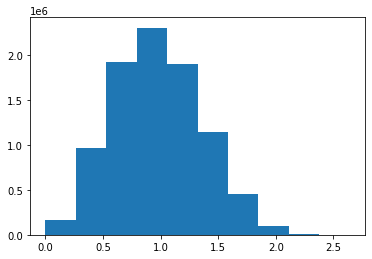

In [391]:
plt.hist(np.ravel(dist_mat))

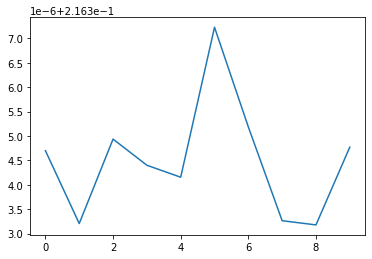

In [412]:
plt.plot([item[0] for item in all_tolerance_vals])

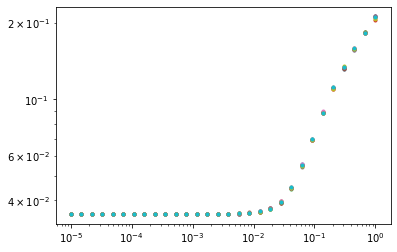

In [417]:
for item in all_tolerance_vals:
    plt.loglog(nu_vals, item[:-1], '.')

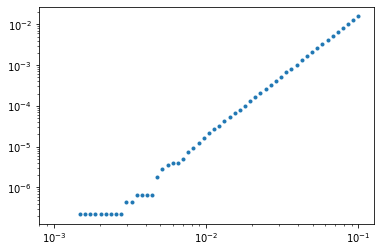

In [226]:
eps_vals = np.logspace(-3, -1, 60)
fraction_neighbors = list()
for eps in eps_vals:
    dist_mat_bin = np.copy(dist_mat_min < eps).astype(int)
    frac_n = np.sum(dist_mat_bin) / float(dist_mat_bin.size)
    fraction_neighbors.append(frac_n)
    
plt.loglog(eps_vals, fraction_neighbors, '.')

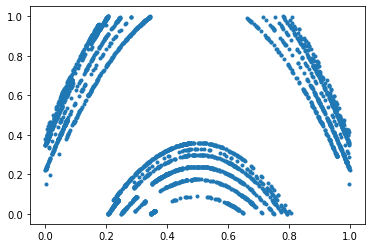

In [6]:
plt.plot(guide_attractor_set[0][:, 0], guide_attractor_set[0][:, 1],'.')
# plt.plot(guide_attractor[:, 0] + 0.05*np.random.random(guide_attractor[:, 0].shape), 
#          guide_attractor[:, 1]+ 0.05*np.random.random(guide_attractor[:, 0].shape),
#          '.')

In [ ]:
### Make a dist_mat object corresponding to the closest approach at any point?

In [9]:
class DisjointSet:
    """
    A disjoint set data structure
    
    https://stackoverflow.com/a/69063762/3238875
    """
    class Element:
        def __init__(self):
            self.parent = self
            self.rank = 0
            
    def __init__(self):
        self.elements = {}

    def find(self, key):
        el = self.elements.get(key, None)
        if not el:
            el = self.Element()
            self.elements[key] = el
        else: # Path splitting algorithm
            while el.parent != el:
                el, el.parent = el.parent, el.parent.parent
        return el

    def union(self, key=None, *otherkeys):
        if key is not None:
            root = self.find(key)
            for otherkey in otherkeys:
                el = self.find(otherkey)
                if el != root:
                    # Union by rank
                    if root.rank < el.rank:
                        root, el = el, root
                    el.parent = root
                    if root.rank == el.rank:
                        root.rank += 1

    def groups(self):
        result = { el: [] for el in self.elements.values() 
                          if el.parent == el }
        for key in self.elements:
            result[self.find(key)].append(key)
        return result
    
def solve(lists):
    disjoint = DisjointSet()
    for lst in lists:
        disjoint.union(*lst)
            
    groups = disjoint.groups()
    return [lst and groups[disjoint.find(lst[0])] for lst in lists]

merged_inds = solve([list(item) for item in all_merged_inds])
merged_inds = [np.sort(np.array(item)) for item in merged_inds]
indlist_lens = np.array([len(item) for item in merged_inds])

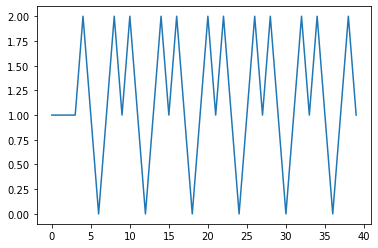

In [17]:


known_items = list()
item_labels = list()

for item in merged_inds:
    i = 0
    add_flag = False
    for j, known_item in enumerate(known_items):
        if allclose_len(item, known_item):
            item_labels.append(j)
            add_flag = True
    if not add_flag:
        known_items.append(item)
        item_labels.append(i + 1)
item_labels = np.array(item_labels)


plt.plot(item_labels[:40])

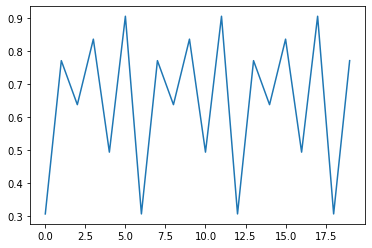

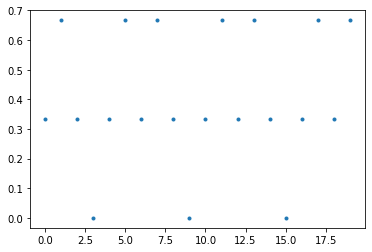

In [11]:
plt.figure()
plt.plot(vals_drive[:20])

plt.figure()
plt.plot(item_labels[m:20+m]/len(np.unique(item_labels)), '.')

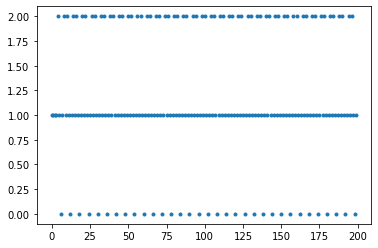

In [12]:

plt.plot(item_labels[:200], '.')

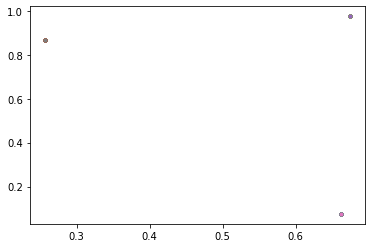

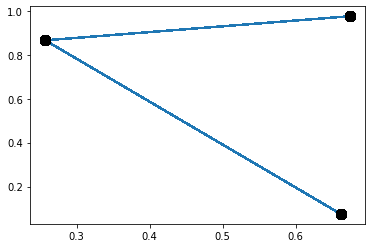

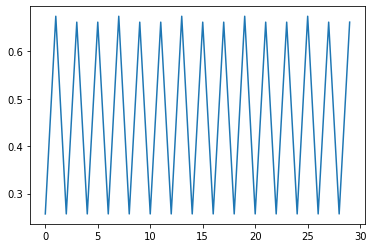

In [13]:
class_example = list()
plt.figure()
for label in item_labels:

    #plt.plot(*reference_attractor[item_labels==label].T[:2], '.')

    plt.plot(*reference_attractor[item_labels==label].T[:2, 0], '.')
    class_example.append(reference_attractor[item_labels==label][0])
class_example = np.array(class_example)


## Plot results

plt.figure()
plt.plot(class_example[:, 0], class_example[:, 1])
plt.plot(class_example[:, 0], class_example[:, 1], '.k', markersize=20)

plt.figure()
plt.plot(class_example[5:35, 0])

# Case with noise

Need a graph partitioning method that can detect disjoint sets




# propagate the fibers

# recurrence epsilon: provides evidence that a set of indices lies on a fiber
# pooling: combine all recurrences together

# Alternative: a voting rule: 
# an index only lies on the fiber if it occurs in at least x% of the time relative to random chance

# correlation sum: the fraction of pairs whose distance is smaller than r


What is the union-find operation doing? It's associating indices which might not otherwise associate. So it's different than a clustering on the distance matrix
+ If i and k co-occur at a time t, and k and j co-occur at a time t', then i, j, k will end up in the same equivalence class, regardless of t - t' 
+ The other neighbors of a point are like the features
+ so want to define a fuzzy set

Machine learning for set assignment: is this just classification of each index?


The next step will be classifying indices based on an unordered set of set barcodes


Newman-Girvan is very expensive for large graphs. What about Louvain?

In [570]:
## Equivalence classes: Community detection using the distance matrix

from communities.algorithms import louvain_method, girvan_newman, hierarchical_clustering

# dist_mat2 = dist_mat - np.eye(dist_mat.shape[0]) * dist_mat
# labels = louvain_method(dist_mat2[:300, :300])

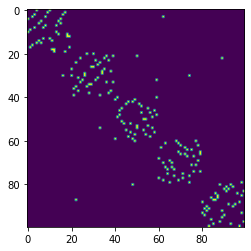

In [429]:
## Simulate a disjoint but weakly connected graph

test_adj = np.zeros((100, 100))
n = 20
for i in range(5):
    base_ind = i * n
    ind_order = base_ind + np.random.choice(np.arange(n), n, replace=False)
    
    # check for diagonal (forbidden)
#     while np.any(ind_order == np.arange(n)):
#         for j in range(20):
#             if ind_order[j] == j:
#                 swap_int = np.random.randint(n)
#                 ind_order[j], ind_order[swap_int] = ind_order[swap_int], ind_order[j]

    for j in range(19):
        test_adj[ind_order[j], ind_order[j+1]] = 1
        test_adj[ind_order[j+1], ind_order[j]] = 1

for i, j in np.random.randint(99, size=(15, 2)):
    test_adj[i, j] = 1
test_adj = hollow_matrix(test_adj)

plt.imshow(test_adj)


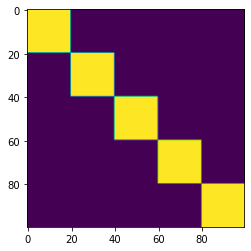

In [13]:
test_adj = np.zeros((100, 100))
for i in range(5):
    test_adj[i*20:(i+1)*20, i*20:(i+1)*20] = 1

# for i, j in np.random.randint(99, size=(40, 2)):
#     test_adj[i, j] = 1
    
plt.imshow(test_adj)

In [104]:
import networkx as nx

dist_graph = sort_graph(nx.from_numpy_matrix(hollow_matrix(dist_mat[:1000, :1000])))
dist_graph_bin = sort_graph(nx.from_numpy_matrix(hollow_matrix(dist_mat_bin.astype(int))))
test_graph_bin = sort_graph(nx.from_numpy_matrix(hollow_matrix(test_adj)))


NameError: name 'test_adj' is not defined

+ Need to find a method that will spit out my results from above (ie, can find disjoint)
+ Use an evidence / voting system to decide set membership
+ Require a minimum union size to merge. How to determine this setting?
+ Instead of true union, a sum over weights as the merge condition
+ What is Binomial distribution probability of overlap between two sets? That can be our merge condition

+ Base probability of overlap, assuming noise dominates: total overlaps / total timepoints

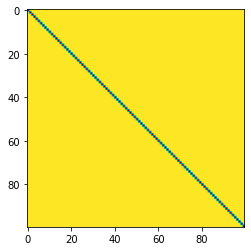

In [882]:
time_exclude = 0

mask_mat = np.ones((100,100))
mask_mat = 1 - (np.triu(mask_mat, k=-time_exclude) * np.tril(mask_mat, k=time_exclude))

plt.imshow(mask_mat)

In [ ]:
## Use epsilon to calculate the typical number of neighboring timepoints that fall within it

In [10]:
dist_graph_bin = sort_graph(nx.from_numpy_matrix(hollow_matrix(dist_mat_bin.astype(int))))
print(nx.number_connected_components(dist_graph_bin))

weight_graph = sort_graph(nx.from_numpy_matrix(weight_matrix))
dist_graph_bin3 = graph_from_associations(hollow_matrix(dist_mat_bin))
dist_graph_bin3 = sort_graph(dist_graph_bin3)
print(nx.number_connected_components(dist_graph_bin3))

dist_graph_bin4 = graph_from_associations(hollow_matrix(dist_mat_bin), weighted=True)
dist_graph_bin4 = sort_graph(graph_threshold(dist_graph_bin4, 2))
print(nx.number_connected_components(dist_graph_bin4))

1
1
1


In [15]:
from sklearn.base import BaseEstimator, ClusterMixin

import scipy.sparse as sp
import warnings

def sparsity(a):
    """Compute the sparsity of a dense matrix"""
    sparsity = 1.0 - (np.count_nonzero(a) / float(a.size) )
    return sparsity

def adjmat_from_associations(mat, weighted=False, use_sparse=False):
    """
    Given an association matrix, create an adjacency matrix 
    representing a graph
    
    All non-zero elements occurring within a row  of the input
    matrix are assumed to be densely connected to eachother, 
    forming a clique in the output matrix
    
    Example:
    [0, 1, 1],
    [1, 1, 0],
    [1, 0, 1]
    --->
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    
    Starting from the edges
    0 -- 1
    0 -- 2
    2 -- 2
    We add the additional edges
    0 -- 0
    1 -- 2
    """
    
    if use_sparse:
        row_inds = list()
        col_inds = list()
        vals = list()
        for row in mat:
            inds = np.where(row)[0]
            for ind_pair in itertools.combinations(inds, 2):
                row_inds += [ind_pair[0], ind_pair[1]]
                col_inds += [ind_pair[1], ind_pair[0]]
                vals += [1, 1]
        g_adj = sp.csr_matrix((vals, (row_inds, col_inds)), shape=mat.shape)
        
# NOT IMPLEMENTED: Weighted
#     g_adj = g_adj.todense()
#     if not weighted:
#         g_adj[g_adj > 0] = 1
    else:
        
        g_adj = np.zeros(mat.shape)
        for row in mat:
            inds = np.where(row)[0]
            for ind_pair in itertools.combinations(inds, 2):
                g_adj[ind_pair[0], ind_pair[1]] += 1
                g_adj[ind_pair[1], ind_pair[0]] += 1
        
        ## Is this step even needed?
        if not weighted:
            g_adj[g_adj > 0] = 1
    
    return g_adj

def _leiden(g, method="graspologic", objective="modularity", resolution=1.0):
    """
    Compute the Leiden clustering of a graph, represented by a numpy matrix or a sparse
    matrix.
    
    Args:
        g (ndarray or sparse_csr_matrix): a representation of a graph as a matrix or 
            sparse matrix.
        method ("graspologic" | "leidenalg" | "igraph" | "cdlib"): The algorithm to use
            to compute the Leiden clustering
        objective ("modularity" | "cpm") : the Leiden clustering method to use
    
    Returns:
        indices (ndarray): An ordered list of indices of nodes in g
        labels (ndarray): A list of labels for each point in indices
    
    """
    if objective not in ["modularity",  "cpm"]:
        warnings.warn("Objective function not recognized; falling back to modularity")
        objective = "modularity"
    ## Convert graph to appropriate format
    if method in ["igraph", "leidenalg"]:
        import igraph as ig
        g_ig = ig.Graph.Adjacency(g).as_undirected()

    if method in ["cdlib"]:
        import networkx as nx
        if sp.issparse(g):
            g_nx = nx.convert_matrix.from_scipy_sparse_matrix(g)
        else:
            g_nx = nx.convert_matrix.from_numpy_matrix(g)    

    ## Find communities       
    if method == "graspologic":
        import graspologic
        mod_flag = (objective == "modularity")
        partition = graspologic.partition.leiden(g, use_modularity=mod_flag, 
                                                 resolution=resolution)
        indices, labels = np.array([(key, partition[key]) for key in partition]).T

    if method == "igraph":
        cluster_obj = g_ig.community_leiden(objective_function=objective, 
                                            resolution_parameter=1.0
                                           )
        labels = cluster_obj.membership
        indices = np.arange(len(labels))


    if method == "cdlib":
        import cdlib
        if objective == "modularity":
            coms = cdlib.algorithms.leiden(g_nx)
        elif objective == "cpm":
            coms = cdlib.algorithms.cpm(g_nx)
        else:
            warnings.warn("Objective function not recognized; falling back to modularity")
        indices, labels = np.array(community_list_to_labels(coms.communities)).T

    if method == "leidenalg":
        import leidenalg as la
        if objective == "modularity":
            objective_obj = la.ModularityVertexPartition
        else:
            objective_obj = la.CPMVertexPartition
        cluster_membership = la.find_partition(g_ig, objective_obj)
        labels = cluster_membership._membership
        indices = np.arange(len(labels))
        
    ## sort output
    sort_inds = np.argsort(indices)
    indices, labels  = indices[sort_inds], labels[sort_inds]

    return indices, labels


    
class RecurrenceClustering(BaseEstimator, ClusterMixin):
    """
    Cluster points in a set of time series using recurrence families
    
    Attributes:
        tolerance (float): The expected fraction of recurrence events in the time series
            This defaults to 1% of all timepoints. Increasing this parameter improves 
            noise robustness, at the expense of decreasing the detail with which the
            driver can be resolved
        noise (float): The amplitude of the noise used to blur the input data (for 
            regularization).
        make_embedding (bool): Perform a time delay embedding before computing the 
            distance matrix. If multivariate time series are passed, each channel is 
            treated as an independent time series. Otherwise, the time series are 
            assumed to already have been embedded.
        metric ("euclidean" or "dtw"): Not Implemented. The metric to use to compute the
            distance matrix
        time_exclude (int): The number of neighboring timepoints to exclude from the 
            neighborhood calculation

    To do:
        Alternative distance metrics; implicit embedding via DTW calculation
        Matrix profile for acceleration
        Subclass for time series motif detection?
    
    """
    
    def __init__(self, tolerance=0.01,
                 resolution=1.0, 
                 d_embed=3, 
                 noise=0.0, 
                 eps=0.025, 
                 random_state=None, 
                 make_embedding=True,
                time_exclude=0
                ):
        
        self.tolerance = tolerance
        self.eps = eps
        self.resolution = resolution
        self.make_embedding = make_embedding
        self.d_embed = d_embed
        self.noise = noise
        self.random_state = random_state
        self.time_exclude = time_exclude
    
    @staticmethod
    def _embed(X, m):
        """
        Create a time delay embedding of a time series or a set of time series
        
        Args:
            X (array-like): A matrix of shape (n_series, n_timepoints) or 
                of shape (n_timepoints)
            m (int): The number of dimensions 
        """
        Xp = hankel_matrix(X, m)
        Xp = np.moveaxis(Xp, (0,1,2), (1,2,0))
        return Xp
    
    def fit(self, 
            X, 
            objective="modularity", 
            weighted=False, 
            method="graspologic", 
            use_sparse=False
           ):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)        
        """
        np.random.seed(self.random_state)
        
        # X is a stack of time series; embed each one
        # separately
        if self.make_embedding:
            ## Flatten multidimensional series
            X = np.reshape(X, (X.shape[0], -1))
            X = standardize_ts(X)
            ## Time delay embedding
            X_embed = self._embed(X, self.d_embed)
        else:
            X_embed = X.copy()
            
        ## Regularization
        X_embed += self.noise *  (np.random.random(X_embed.shape) - 0.5)
        
        all_dist_mat = np.sqrt(
            np.sum(
                (X_embed[..., None, :] - X_embed[:, None, ...])**2, 
                axis=-1
            )
        ).T
        all_dist_mat += (np.eye(all_dist_mat.shape[0]) * 1e16)[..., None]

        dist_mat_min = np.min(all_dist_mat, axis=-1)
        #weight_matrix = 1 / dist_mat_min
        
        eps = self.eps
        eps = np.percentile(np.ravel(dist_mat_min), 100 * self.tolerance)
        print(f"Selected threshold is {eps}")
        
        dist_mat_bin = np.copy(dist_mat_min < eps).astype(int)
        print(f"Distance matrix sparsity is is {sparsity(dist_mat_bin)}")
        
        if self.time_exclude > 0:
            mask_mat = np.ones_like(dist_mat_min)
            mask_mat = 1 - (np.triu(mask_mat, k=-self.time_exclude) 
                            * np.tril(mask_mat, k=self.time_exclude))
            dist_mat_bin *= mask_mat.astype(int)
            
        amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                        weighted=weighted,
                                        use_sparse=use_sparse)
        
        
        
        self.neighbor_matrix = amat # dist_mat_bin
        self.distance_matrix = dist_mat_min
        self.data_matrix = X_embed
        self.a_matrix = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                                 weighted=weighted,
                                                 use_sparse=use_sparse)
        
        
        
        
        
        
        indices, labels = _leiden(
            amat, 
            resolution=self.resolution,
            objective=objective,
            method=method
        )
        sort_inds = np.argsort(indices)
        indices, labels = indices[sort_inds], labels[sort_inds]
        reference_indices = np.arange(amat.shape[0])
        
#         missing_vals = np.setxor1d(reference_indices, indices)
#         unclassified_inds = arg_find(reference_indices, missing_vals)
        
        self.indices = np.copy(reference_indices)
        self.labels_ = -np.ones_like(self.indices)
        self.labels_[indices] = labels
        
#         print(indices.shape, labels.shape)
#         self.indices = indices
#         self.labels_ = labels
        self.has_unclassified = np.any(self.labels_ < 0)
        self.n_clusters = len(np.unique(self.labels_)) - self.has_unclassified
    
    def get_driving(self, X):
        """
        Return the best estimate of the driving signal, using a maximum variance 
        heuristic
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        DEV: switch to a heuristic that maximizes spacing
        """
        vals_recon = self._get_full_driving(X)
                
        # Select best cycle example using largest variance principle
        max_spread_inds = np.argmax(np.sum(np.var(vals_recon, axis=1), 
                                           axis=-1), axis=-1)
        
        vals_recon = vals_recon[np.arange(len(max_spread_inds)), 
                                      :, max_spread_inds]
        return vals_recon
        
    
    def _get_full_driving(self, X):
        """
        Return all possible estimates of the driving signal across system. Negative 
        indices are ignored
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        Returns:
            class_example (np.ndarray): An array of shape (B, T, Te, D), where B is 
                the index of an input dataset for reconstruction, T is the effective 
                time index of the reconstructed signal. Te indexes particular points on 
                the driver. Each value of Te corresponds to a particular driver 
                representation.
        
        """
        
        X = np.reshape(X, (X.shape[0], -1))
        X = standardize_ts(X) ## check this
        X_embed = self._embed(X, self.d_embed)
        # (B, T, D)
    
        class_example = list()
        for label in np.unique(self.labels_):
            if label < 0: continue
            #class_example.append(X_embed[:, self.labels_==label, :][:, 0])
            class_example.append(X_embed[:, self.labels_==label, :])
        time_cap = min([item.shape[1] for item in class_example])
        class_example = [item[:, :time_cap] for item in class_example]
        class_example = np.array(class_example)
        class_example = np.moveaxis(class_example, (0,1,2), (1,0,2))
        
        return class_example

    def transform(self, X):
        """
        Creates an embedding of a dataset based on the labels list
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            
        """
        cycle_vals = self.get_driving(X)
        all_cycles = list()
        for i in range(cycle_vals.shape[0]):
            sel_inds = self.labels_[self.labels_ >= 0]
            all_cycles.append(cycle_vals[i][sel_inds])
        return np.array(all_cycles)

    def fit_transform(self, X, y=None):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            y (ignored) : Not used, present here for consistency with sklearn API
        """
        return self.fit(X).transform(X)
    
class RecurrenceManifold(RecurrenceClustering):
    
    def __init__(self):
        super().__init__()

# class ClassicalRecurrenceClustering(RecurrenceClustering):
    
vals_response = sol_response[:, :, 0].T
    
model = RecurrenceClustering(resolution=1.0, tolerance=0.01)
label_vals = model.fit_predict(vals_response)
vals_recon = model.get_driving(vals_response)
vals_embedded = model.transform(vals_response)
# model = RecurrenceClustering()
# model.fit(vals_response)

# plt.figure()
# plt.plot(label_vals[:20],'-k')
# plt.plot(label_vals[:20],'.k')

plt.figure()
plt.plot(label_vals[:200],'-k')
plt.plot(label_vals[:200],'.k')

plt.figure()
plt.plot(sol_response[0, :200, 0],'-k')

plt.figure()
plt.plot(sol_drive[:200,0],'-k')

plt.figure()
plt.plot(sol_drive[:200, 0], label_vals[:200], 'k')

NameError: name 'sol_response' is not defined

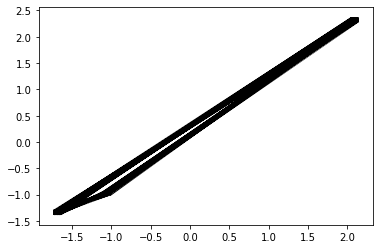

In [880]:
plt.plot(
    vals_embedded[0][:, 0] + 0.1*np.random.random(vals_embedded[0][:, 0].shape), 
    vals_embedded[0][:, 1] + 0.1*np.random.random(vals_embedded[0][:, 1].shape),
    linewidth=0.5, color='k'
)

In [907]:
# def amat_to_data(a):
#     """
#     Given an adjacency matrix, produce a samples x features data matrix with 
#     the corresponding graph
#     """


import scanpy as sc

# model.a_matrix

data_matrix = np.copy(model.data_matrix)
distance_matrix = np.copy(model.distance_matrix)
neighbor_matrix = np.copy(model.neighbor_matrix)

ndim = embed_matrix.shape[-1]

In [908]:
adata = sc.AnnData(0*data_matrix[0, :-ndim, :])

sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

adata.obsp["distances"] = scipy.sparse.csr_matrix(distance_matrix[:-3, :-3])
adata.obsp["connectivities"] = scipy.sparse.csr_matrix(neighbor_matrix[:-3, :-3])
adata.uns['iroot'] = 0

sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=0)

/Users/williamgilpin/miniconda3/envs/ndyn/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:921: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0 / q, 0, W.shape[0], W.shape[0])
/Users/williamgilpin/miniconda3/envs/ndyn/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:931: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0 / z, 0, K.shape[0], K.shape[0])


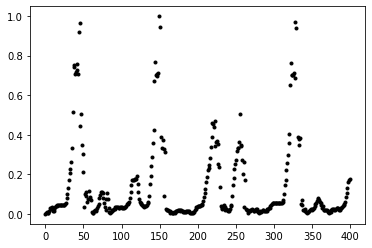

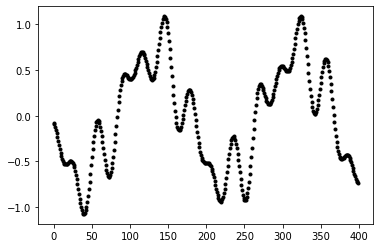

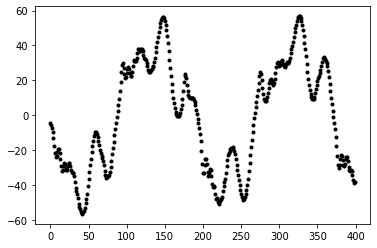

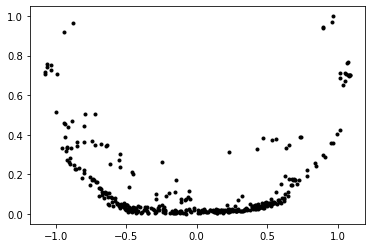

In [909]:
pt_vals = np.array(adata.obs["dpt_pseudotime"])
pt_vals[np.isinf(pt_vals)] = None
# pt_vals = pt_vals[~np.isinf(pt_vals)]


n_plt = 400

plt.figure()
plt.plot(pt_vals[:n_plt], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], '.k')

plt.figure()
plt.plot(sol_response[0, :n_plt, 0], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], pt_vals[:n_plt], '.k')

In [ ]:
# def amat_to_data(a):
#     """
#     Given an adjacency matrix, produce a samples x features data matrix with 
#     the corresponding graph
#     """


import scipy
import scanpy as sc

# model.a_matrix

data_matrix = np.copy(model.data_matrix)
distance_matrix = np.copy(model.distance_matrix)
neighbor_matrix = np.copy(model.neighbor_matrix)

ndim = data_matrix.shape[-1]




adata = sc.AnnData(0*data_matrix[0, :-ndim, :])

sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

adata.obsp["distances"] = scipy.sparse.csr_matrix(distance_matrix[:-3, :-3])
adata.obsp["connectivities"] = scipy.sparse.csr_matrix(neighbor_matrix[:-3, :-3])
adata.uns['iroot'] = 0

sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=0)


pt_vals = np.array(adata.obs["dpt_pseudotime"])
pt_vals[np.isinf(pt_vals)] = None
# pt_vals = pt_vals[~np.isinf(pt_vals)]


n_plt = 3000

plt.figure()
plt.plot(pt_vals[:n_plt], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], '.k')

plt.figure()
plt.plot(sol_response[0, :n_plt, 0], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], pt_vals[:n_plt], '.k', markersize=1)

In [240]:
def dist2coords(d):
    """
    Given a distance matrix, produce a corresponding coordinate matrix
    """
    m = 0.5 * (d[0, :1]**2 + d[:1, 0]**2 + d**2)
    eigs, vecs = np.linalg.eigh(m)
    xout = vecs @ np.sqrt(np.diag(eigs))
    return xout

ww = dist2coords(distance_matrix)

In [841]:
sc.tl.draw_graph(adata)
sc.tl.draw_graph(adata, color=['dpt_pseudotime'])

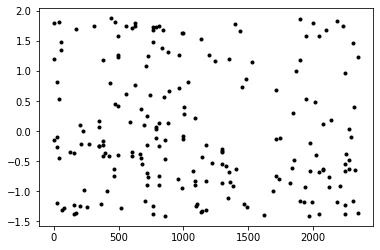

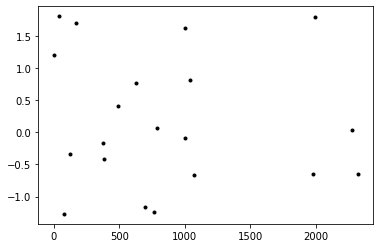

In [829]:
plt.figure()
plt.plot(np.argsort(pt_vals)[:200], embed_matrix[0, :-3, 0][:200], '.k')

plt.figure()
plt.plot(np.argsort(pt_vals)[:20], embed_matrix[0, :-3, 0][:20], '.k')

In [144]:
np.argsort(pt_vals)

array([   0, 1452, 2430, ..., 1215, 1195, 1497])

In [123]:
adata.obsm['X_diffmap'].shape

(2995, 15)

(array([ 126.,  244.,  434.,  672., 1516., 1210.,  740., 1050.,  702.,
        4536.]),
 array([0.00738969, 0.10665073, 0.20591176, 0.30517277, 0.40443382,
        0.50369483, 0.6029559 , 0.7022169 , 0.8014779 , 0.90073895,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

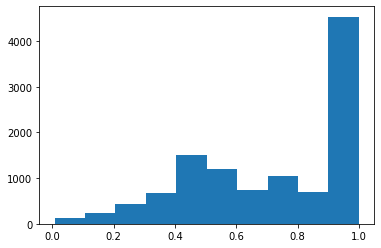

In [92]:
qq = np.ravel(np.array(adata.obsp["connectivities"].todense()))
qq = qq[qq>0]
plt.hist(np.sort(
    qq
))

(array([8.589e+03, 3.800e+02, 4.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00]),
 array([3.36185508e-07, 1.07007317e-01, 2.14014298e-01, 3.21021280e-01,
        4.28028261e-01, 5.35035242e-01, 6.42042223e-01, 7.49049204e-01,
        8.56056185e-01, 9.63063166e-01, 1.07007015e+00]),
 <BarContainer object of 10 artists>)

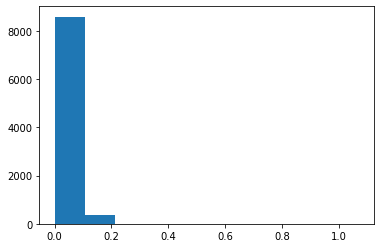

In [94]:
qq = np.ravel(np.array(adata.obsp["distances"].todense()))
qq = qq[qq>0]
plt.hist(np.sort(
    qq
))

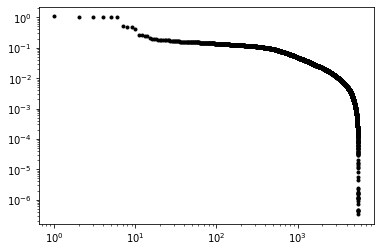

In [32]:
plt.loglog(np.unique(q1)[::-1],'.k')

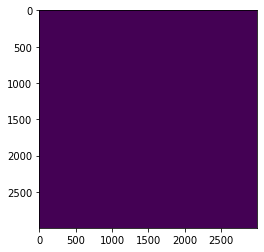

In [71]:
q1 = np.array(adata.obsp["distances"].todense())
plt.imshow(q1)

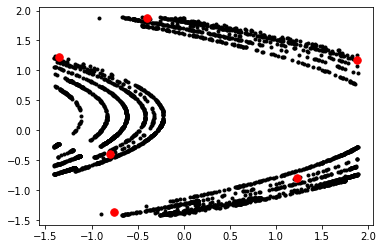

In [459]:


qq = np.reshape(vals_recon[0], (-1, vals_recon[0].shape[-1]))
plt.plot(qq[:, 0], qq[:,1], '.k')

max_spread_inds = np.argmax(np.sum(np.var(vals_recon[...,:2], axis=1), axis=-1), axis=-1)

# for item in vals_recon:
# plt.figure()
# plt.plot(vals_recon[0, :, max_spread_inds[0], 0], 
#          vals_recon[0, :, max_spread_inds[0], 1], 
#          '.r', markersize=15)

qq = vals_recon[np.arange(len(max_spread_inds)), :, max_spread_inds]

plt.plot(qq[0, :, 0], qq[0, :, 1], '.r', markersize=15)

In [369]:
# [item.shape for item in ww]

In [299]:
all_attractors.shape

(4, 2998, 3)

In [12]:
true_data[:1000, :10]

(3137, 100)

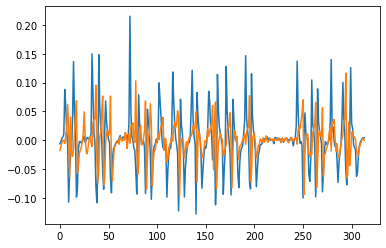

In [55]:
plt.plot(true_data[::10, 0])
plt.plot(true_data[::10, 1])

In [88]:
true_data = np.load("test4.pkl", allow_pickle=True)

In [19]:
true_data.shape

(1000, 10)

In [ ]:
## big issue with data that returns to a value like zero

In [42]:
true_data = np.load("test4.pkl", allow_pickle=True)
highest_variance = np.argsort(np.var(true_data, axis=0))[::-1]
true_data = true_data[:, highest_variance]

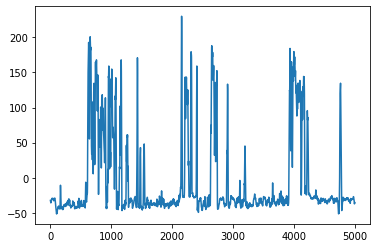

In [117]:
plt.plot(data_transformed[:5000, 0])

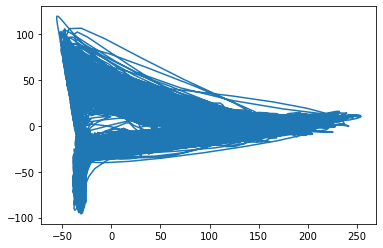

In [52]:
true_data = np.load("test4.pkl", allow_pickle=True)
from sklearn.decomposition import PCA
embedding = PCA()
data_transformed = embedding.fit_transform(true_data)

plt.plot(data_transformed[:, 0], data_transformed[:,1])

In [ ]:

def fread(fid, nelements, dtype):
    if dtype is str:
        dt = np.uint8  # WARNING: assuming 8-bit ASCII for np.str!
    else:
        dt = dtype

    data_array = np.fromfile(fid, dt, nelements)
    data_array.shape = (nelements, 1)

    return data_array

fpath = "data/1.bin"
with open(fpath, 'rb') as fid:
    fs = fread(fid, 1, '<f8')
    rows = fread(fid, 1, '<u8')
    cols = fread(fid, 1, '<f8')
    data = np.fromfile(fid, dtype='<f8')

if int(rows * cols) == int(np.prod(data.shape)):
    data = np.reshape(data, (int(cols), int(rows)))

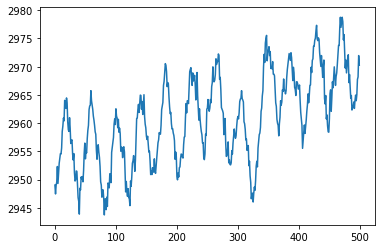

In [103]:
plt.plot(data[:500, 3])
# plt.plot(data[:200, 1])

In [157]:
true_data = np.load("data_elec.pkl", allow_pickle=True)
ranked_by_missing = np.argsort(np.sum(true_data == 0, axis=0))
true_data = true_data[:, ranked_by_missing[:10]]

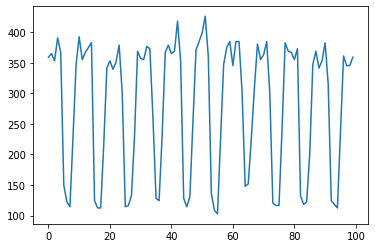

In [171]:
plt.plot(true_data[:100, 0])

plt.plot(true_data[:100, 0])

Selected threshold is 0.0822153493505287
Distance matrix sparsity is is 0.9900000144346223


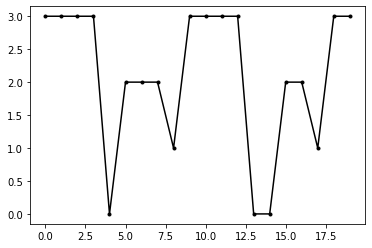

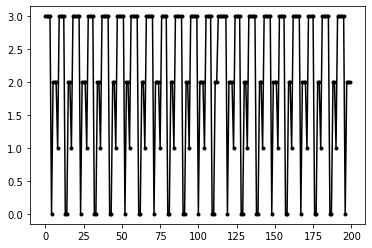

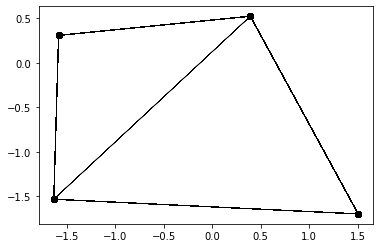

In [173]:
from scipy.signal import savgol_filter

# true_data = np.load("test2.pkl", allow_pickle=True).T
# true_data = np.load("test3.pkl", allow_pickle=True)[:, :10][::3, :]
# true_data = np.load("test4.pkl", allow_pickle=True)[:10000, :20]

# true_data = np.load("test4.pkl", allow_pickle=True)
# highest_variance = np.argsort(np.var(true_data, axis=0))[::-1]
# # true_data = true_data[:5000, highest_variance]
# true_data = true_data[::10][:4000, highest_variance[:5]]

# from sklearn.decomposition import PCA
# true_data = np.load("test4.pkl", allow_pickle=True)
# embedding = PCA()
# data_transformed = embedding.fit_transform(true_data)
# true_data = data_transformed[::1][:4000, :10]

# ## Interpeak distance
# from scipy.signal import find_peaks
# true_data = np.load("test4.pkl", allow_pickle=True)
# highest_variance = np.argsort(np.var(true_data, axis=0))[::-1][:10]
# true_data = true_data[:, highest_variance]
# all_inds = list()
# for row in true_data.T:
#     all_inds.append(np.diff(find_peaks(row)[0]))
# min_len = min([len(item) for item in all_inds])
# true_data = np.vstack([item[:min_len] for item in all_inds]).T


## Natal ECG data
# data_trend = savgol_filter(data, 1001, 3, axis=0)
# data_detrended = data - data_trend
# true_data = data_detrended[::6][:5000, :20]

# model = RecurrenceClustering(d_embed=3, resolution=1.0)
# model.fit(true_data)
# traj = model.transform(true_data)


true_data = np.load("data_elec.pkl", allow_pickle=True)
ranked_by_missing = np.argsort(np.sum(true_data == 0, axis=0))
true_data = true_data[::10][:2500, ranked_by_missing[:20]]

model = RecurrenceClustering(d_embed=3, resolution=1.0)
model.fit(true_data)
traj = model.transform(true_data)


plt.figure()
plt.plot(model.labels_[:20],'-k')
plt.plot(model.labels_[:20],'.k')

plt.figure()
plt.plot(model.labels_[:200],'-k')
plt.plot(model.labels_[:200],'.k')

plt.figure()
plt.plot(traj[0, :, 0], traj[0, :, 2], '.k', markersize=10)
plt.plot(traj[0, :, 0], traj[0, :, 2], 'k', linewidth=0.4)

## summer to fall seasonal transition over 93 days. 23 July to 23 October, 2010

### LOOK
+ Can one calculate pseudotime from the distance matrix to get a continuous label?
+ Get weighted graphs working as a way to potentially filter cycles

In [ ]:
model._get_driving

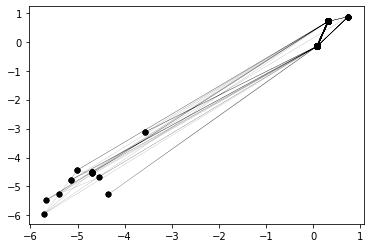

In [854]:
plt.figure()
plt.plot(traj[0, :, 0], traj[0, :, 2], '.k', markersize=10)
plt.plot(traj[0, :, 0] + 0.005 * np.random.normal(size=traj[0, :, 0].shape), 
         traj[0, :, 2] + 0.005 * np.random.normal(size=traj[0, :, 0].shape), 
         'k', linewidth=0.1)
# plt.xlim([-0.25, 0.6])
# plt.ylim([-0.3, 0.6])

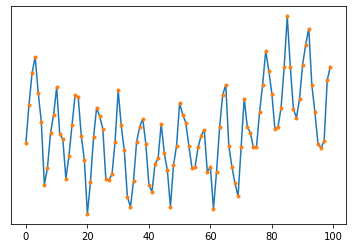

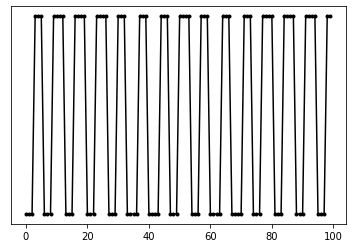

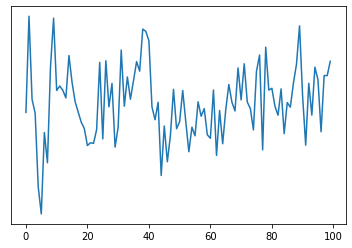

In [107]:
tlen = 100
plt.figure()
plt.plot(data_detrended[::6][:tlen, 1], '-')
plt.plot(data_detrended[::6][:tlen, 1], '.')
# plt.plot(data_detrended[::10][:tlen, 5])
plt.gca().axes.get_yaxis().set_visible(False)

plt.figure()
plt.plot(model.labels_[:tlen],'-k')
plt.plot(model.labels_[:tlen],'.k')
plt.gca().axes.get_yaxis().set_visible(False)

plt.figure()
plt.plot(data_detrended[::10][:tlen, -3])
plt.gca().axes.get_yaxis().set_visible(False)



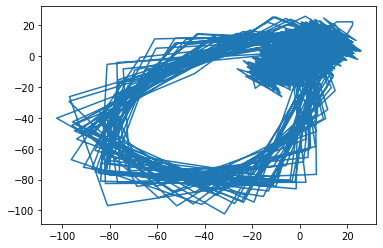

In [777]:
plt.plot(data_detrended[::20][1:, 0], data_detrended[::20][:-1, 0])

# Period-doubling cascade

# Work with continuous-time chaotic system

Consider Fitzhugh-Nagumo example

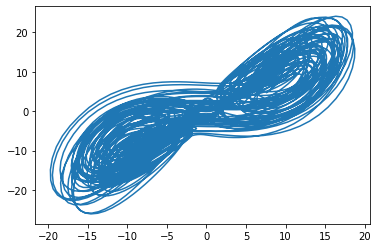

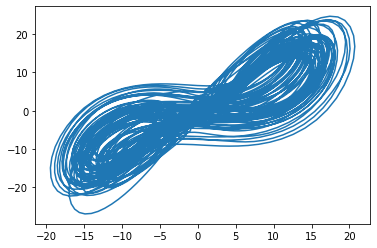

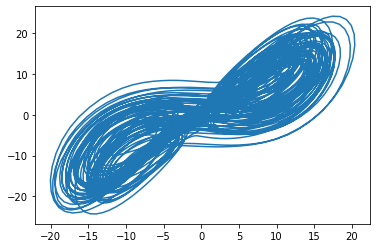

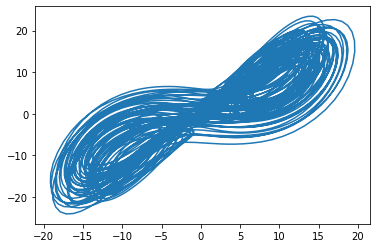

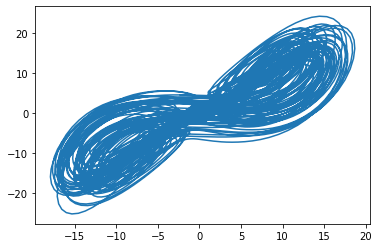

In [90]:
nval = 5

np.random.seed(0)
def lorenz_follower(t, X, 
                    n=nval, 
                    beta=2.667,
                    rho=28 * (1 + 0.1 * (2 * np.random.random(nval) - 1)),
                    sigma=10 * (1 + 0.1 * (2 * np.random.random(nval) - 1)),
                    k = 1 * (1 + 0*(2 * np.random.random(nval) - 1)),
                    omega=2 * np.pi
                   ):
    x, y, z, w = X[:n], X[n:2*n], X[2*n:3*n], X[-1]
    
    wdot = omega * np.cos(omega * t)
    xdot = sigma * (y - x) + 40 * k * w
    ydot = x * (rho - z) - y 
    zdot = x * y - beta * z 
    out = np.hstack([xdot, ydot, zdot, wdot])
    return out

from scipy.integrate import solve_ivp


tpts = np.linspace(0, 100, 10000)
ic = np.random.random(3 * nval + 1)
ic[-1]=0


sol = solve_ivp(lorenz_follower, [min(tpts), max(tpts)], ic, t_eval=tpts[int(0.1*len(tpts)):])
solx, soly, solz, solw = sol.y[:nval], sol.y[nval:2*nval], sol.y[2*nval:3*nval], sol.y[-1]
all_sol = np.dstack([solx, soly, solz])
tvals = sol.t

 # B, T, D
for sol in all_sol:
    plt.figure()
    plt.plot(sol[:, 0], sol[:, 1])

Selected threshold is 0.19217636790590942
Distance matrix sparsity is is 0.950000158870873


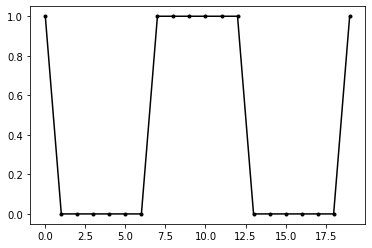

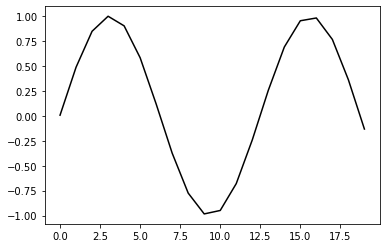

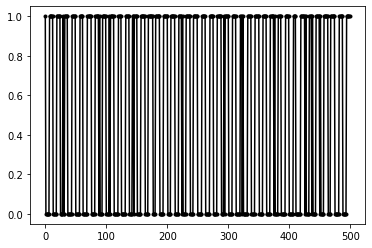

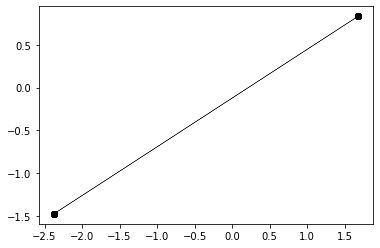

In [101]:
vals_response = np.copy(all_sol[..., 1].T)[::8]
vals_driving =  np.copy(solw)[::8]

model = RecurrenceClustering(resolution=1.0, tolerance=0.05)
model.fit(vals_response, use_sparse=False)
vals_recon = model.get_driving(vals_response)
vals_embedded = model.transform(vals_response)

traj = model.transform(vals_response)

plt.figure()
plt.plot(model.labels_[:20],'-k')
plt.plot(model.labels_[:20],'.k')

plt.figure()
plt.plot(vals_driving[:20],'-k')

plt.figure()
plt.plot(model.labels_[:500],'-k')
plt.plot(model.labels_[:500],'.k')

plt.figure()
plt.plot(traj[0, :, 0], traj[0, :, 2], '.k', markersize=10)
plt.plot(traj[0, :, 0], traj[0, :, 2], 'k', linewidth=0.4)

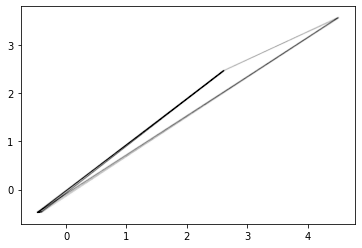

In [ ]:
plt.plot(traj[0, :, 0] + 0.01*np.random.normal(size=traj[0, :, 0].shape), 
         traj[0, :, 2] + 0.01*np.random.normal(size=traj[0, :, 0].shape), 
         'k', linewidth=0.001)

# Experimental Datasets

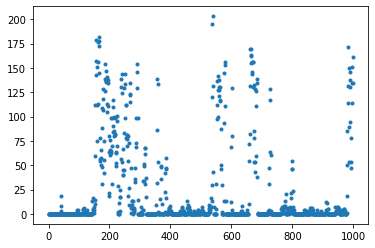

In [142]:
true_data = np.load("test4.pkl", allow_pickle=True)
highest_variance = np.argsort(np.var(true_data, axis=0))[::-1][:5]
true_data = true_data[:5000, highest_variance]

plt.plot(true_data[::4][:1000, 0],'.')

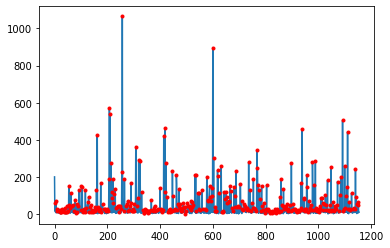

In [103]:




inds = find_peaks(true_data[:, 0])[0]
plt.plot(true_data[:, 0])
plt.plot(inds, true_data[inds, 0], '.r')

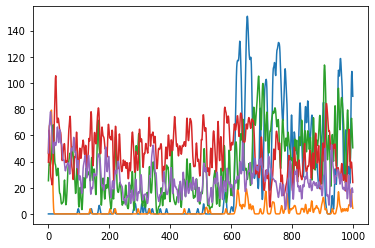

In [31]:
true_data = np.load("test4.pkl", allow_pickle=True)
highest_variance = np.argsort(np.var(true_data, axis=0))[::-1][:5]
true_data = true_data[:, highest_variance]

plt.plot(true_data[:1000]);

In [16]:
# consider accepting embedding instead of defaulting to lag

(10, 732, 3)

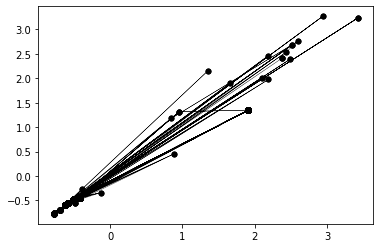

In [62]:
plt.figure()
plt.plot(traj[0, :, 0], traj[0, :, 2], '.k', markersize=10)
plt.plot(traj[0, :, 0], traj[0, :, 2], 'k', linewidth=0.4)

In [12]:
true_data = np.load("test4.pkl", allow_pickle=True)[:400, :10]

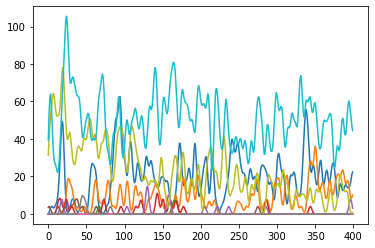

In [13]:
plt.plot(true_data);

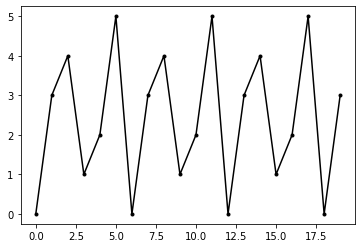

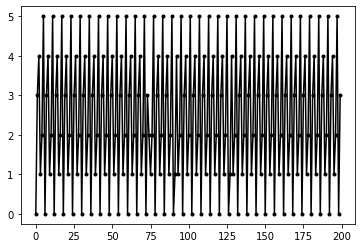

In [221]:
plt.figure()
plt.plot(model.labels_[:20],'-k')
plt.plot(model.labels_[:20],'.k')

plt.figure()
plt.plot(model.labels_[:200],'-k')
plt.plot(model.labels_[:200],'.k')

In [13]:

labels_true = np.zeros_like(vals_drive)
## Use an allclose condition on unique
for i, val in enumerate(np.unique(vals_drive)):
    labels_true[vals_drive == val] = i
labels_true = labels_true.astype(int)
labels_true = labels_true[m:]

In [14]:
amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                     use_sparse=False)

# amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
#                                     weighted=True,
#                                      use_sparse=False)
# amat[amat > 4] = 0
# amat[np.logical_and(amat <= 4, amat > 0)] = 1

indices, labels = _leiden(amat, objective="modularity")

plt.figure()   
plt.plot(labels, '.k')

plt.figure()
plt.plot(labels[30:50])

plt.figure()
plt.plot(labels[:200])

plt.figure()
plt.plot(vals_drive[:200])

KeyboardInterrupt: 

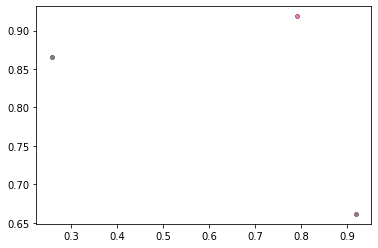

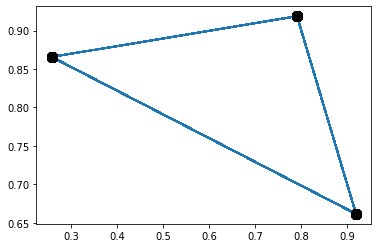

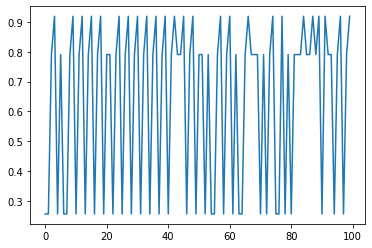

In [118]:
class_example = list()
plt.figure()
for label in labels:
    #plt.plot(*reference_attractor[item_labels==label].T[:2], '.')
    plt.plot(*reference_attractor[labels==label].T[:2, 0], '.')
    class_example.append(reference_attractor[labels==label][0])
class_example = np.array(class_example)


## Plot results
plt.figure()
plt.plot(class_example[:, 0], class_example[:, 1])
plt.plot(class_example[:, 0], class_example[:, 1], '.k', markersize=20)

plt.figure()
plt.plot(class_example[:100, 0])

In [ ]:
amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                    weighted=True,
                                     use_sparse=False)
amat[amat < 4] = 0
amat[amat >= 4] = 1

In [ ]:
amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
                                     use_sparse=False)


# amat = adjmat_from_associations(hollow_matrix(dist_mat_bin), 
#                                     weighted=True,
#                                      use_sparse=False)
# amat[amat > 4] = 0
# amat[np.logical_and(amat <= 4, amat > 0)] = 1

import time

all_assignments = list()
for method_name in ["graspologic", "leidenalg", "igraph", "cdlib"]:
    base_t0 = time.perf_counter()
    indices, labels = _leiden(amat, objective="modularity")
    base_t1 = time.perf_counter()
    base_elapsed = base_t1 - base_t0
    print("\n", method_name, base_elapsed, flush=True)
    all_assignments.append(labels)
#     plt.figure()
#     plt.plot(indices, labels, '.')

    print(evaluate_clustering(labels_true, labels))

0.08405603735823883
0.08405603735823883
0.08372248165443628
0.08372248165443628


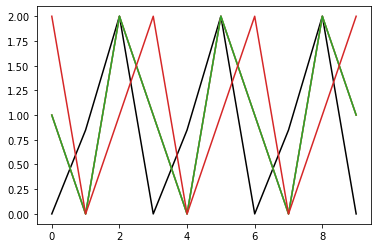

In [211]:
plt.plot(true_sig[:10], 'k')

for item in all_assignments:
    plt.plot(item[:10], '-')
    score1 = np.mean(np.abs(np.sign(labels_true[:len(item)] - item)))
    score2 = np.mean(np.abs(np.sign(2 - labels_true[:len(item)]) - item))
    
    score3 = np.mean(np.abs(np.sign(labels_true[1:len(item)+1] - item)))
    score4 = np.mean(np.abs(np.sign((2 - labels_true[1:len(item)+1]) - item)))
    
    score5 = np.mean(np.abs(np.sign(labels_true[2:len(item)+2] - item)))
    score6 = np.mean(np.abs(np.sign((2 - labels_true[2:len(item)+2]) - item)))
    
    print(min(score1, score2, score3, score4, score5, score6))

In [ ]:
_leiden

In [356]:
%timeit adjmat_from_associations(hollow_matrix(dist_mat_bin), weighted=True)

41.4 s ± 22.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [345]:
%timeit adjmat_from_associations(hollow_matrix(dist_mat_bin), weighted=True)

28.9 s ± 765 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [340]:
%timeit adjmat_from_associations(hollow_matrix(dist_mat_bin), weighted=True)

52.9 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
ee = np.random.random((50,50))
ee += ee.T
ee = (ee < 0.3).astype(int)

qq = ig.Graph.Adjacency(hollow_matrix(ee))

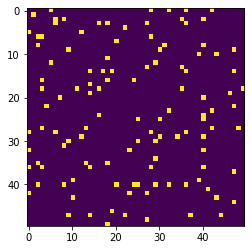

In [65]:
plt.imshow(ee)

In [ ]:
qq = h_ig.community_leiden(objective_function="modularity",resolution_parameter=1.0)

In [68]:
qq.community_leiden(objective_function="modularity")
# cl = G.community_leiden(
#             "CPM", resolution_parameter=1, weights="weight", beta=0, n_iterations=-1
#         )

InternalError: Error at src/community/leiden.c:1015: Leiden algorithm is only implemented for undirected graphs. -- Invalid value

In [358]:
dist_mat_bin33 = nx.convert_matrix.from_scipy_sparse_matrix(g_adj)

In [361]:
dist_mat_bin33

In [231]:
ww = np.array([[1, 0, 0], [0, 0, 1], [1, 1, 1]])

np.argmax(ww, axis=0)

array([0, 2, 1])

In [209]:
import itertools
g = nx.Graph()
g.add_edges_from(itertools.combinations([7, 4, 3, 2], 2))

print(g.edges)

[(7, 4), (7, 3), (7, 2), (4, 3), (4, 2), (3, 2)]


In [200]:
get_all_pairs([7, 4, 3, 2])

[(4, 7), (3, 7), (3, 4), (2, 7), (2, 4), (2, 3)]

In [334]:
dist_graph_bin4_0 = graph_from_associations(hollow_matrix(dist_mat_bin), weighted=True)
dist_graph_bin4 = sort_graph(graph_threshold(dist_graph_bin4_0, 4))
print(nx.number_connected_components(dist_graph_bin4))

1


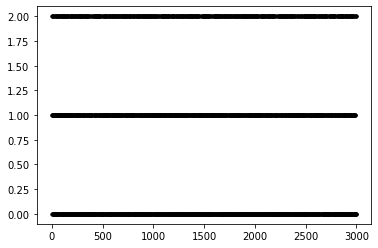

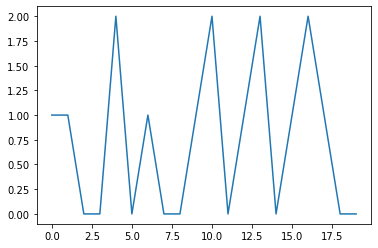

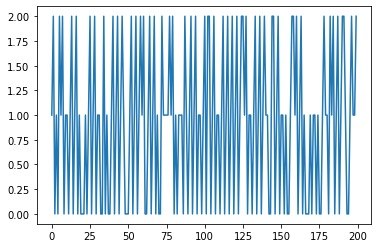

In [12]:
import cdlib.algorithms

# eigenvector, markov_clustering, walktrap, etc all return the same communities,
#cdlib.algorithms.em, belief
# coms = cdlib.algorithms.kclique(dist_graph_bin, 20)
# coms = cdlib.algorithms.louvain(test_graph_bin, resolution=1.0)
# coms = cdlib.algorithms.leiden(test_graph_bin)


# coms = cdlib.algorithms.louvain(dist_graph_bin3, resolution=1e3)
# coms = cdlib.algorithms.leiden(dist_graph_bin3)
# coms = cdlib.algorithms.kclique(dist_graph_bin3, 2)

coms = cdlib.algorithms.leiden(dist_graph_bin3)

# coms = cdlib.algorithms.leiden(weight_graph)
# coms = cdlib.algorithms.eigenvector(weight_graph)

# coms = cdlib.algorithms.threshold_clustering(weight_graph)
# coms = cdlib.algorithms.der(weight_graph)
# coms = cdlib.algorithms.cpm(weight_graph, resolution_parameter=0.9)
# coms = cdlib.algorithms.chinesewhispers(weight_graph, weighting="log")


indices, item_labels = np.array(community_list_to_labels(coms.communities)).T
if not np.all(np.diff(indices) > 0):
    print("Reordering labels. Check why this happened.")
    item_labels = item_labels[np.argsort(indices)]

plt.figure()   
plt.plot(item_labels, '.k')

plt.figure()
plt.plot(item_labels[30:50])

plt.figure()
plt.plot(item_labels[:200])

In [ ]:
g = Graph(n=4, edges=[[0, 1], [2, 3]],
          edge_attrsigr={'weight': [0.1, 0.2]},

In [15]:
# h = ig.Graph.Adjacency(g_adj)

In [ ]:
nx.convert_matrix.from_numpy_matrix(g_adj)

In [52]:
type(sp.csr_matrix(ww))

scipy.sparse.csr.csr_matrix

In [50]:
nx.convert_matrix.from_scipy_sparse_matrix(sp.csr_matrix(ww).todense())

AttributeError: 'matrix' object has no attribute 'format'

In [49]:
ww = np.random.random((50,50))
ww = (ww < 0.3).astype(int)

nx.convert_matrix.from_scipy_sparse_matrix(sp.csr_matrix(ww))

In [97]:
import igraph as ig

ee = np.random.random((50,50))
ee += ee.T
ee = hollow_matrix((ee < 0.3).astype(int))

ee = ig.Graph.Adjacency(ee).as_undirected()

In [112]:
qq = ee.community_leiden(objective_function="modularity", resolution_parameter=1.0)

In [77]:
# %timeit ig.Graph.Adjacency(g_adj)

In [141]:
# graph: index to fibers, not fibers to each other



import networkx as nx

edge_list = [tuple(item) for item in np.vstack(np.where(hollow_matrix(dist_mat_bin))).T]
dist_graph_bin2 = nx.Graph(edge_list)


# dist_graph_bin2 = nx.Graph()
# dist_graph_bin2.add_edges_from(np.vstack(np.where(hollow_matrix(dist_mat_bin))).T)

# dist_graph_bin2 = nx.Graph()
# for ind, row in enumerate(hollow_matrix(dist_mat_bin)):
#     for val in np.where(row)[0]:
#         dist_graph_bin2.add_edge(ind, val)

# isn't this the same as the adjacency matrix?

# perhaps better: each row is a "clique"

# node ordering in networkx graph


In [ ]:

qq = np.array(
    [
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

qq = np.array(
    [
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0],
    ])
nx.number_connected_components(sort_graph(graph_from_associations(qq)))

2

In [ ]:
dist_graph_bin3 = graph_from_associations(hollow_matrix(dist_mat_bin))
dist_graph_bin3 = sort_graph(dist_graph_bin3)

nx.number_connected_components(dist_graph_bin3)

## Test: create one giant component
# dist_graph_bin3.add_edges_from(np.random.randint(dist_mat_bin.shape[0], size=(20000, 2)))

4

In [398]:
nx.number_connected_components(dist_graph_bin)

8

In [ ]:
# why would self-terms increase number of components? Is it singletons?

In [ ]:
# dist_graph_bin2 = nx.Graph()
# for ind, row in enumerate(hollow_matrix(dist_mat_bin)):
#     for val in np.where(row)[0]:
#         dist_graph_bin2.add_edge(ind, val)

In [ ]:
# weighted graphss
graph_entropy	
threshold_clustering
surprise_communities
lswl
infomap
dpclus
der
danmf
dcs
agdl
chinesewhispers	
ipca

In [ ]:
## Use overlapping community detector, followed by a merge rule

In [ ]:
for item in coms.communities:
    print(item)

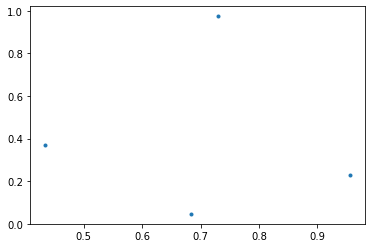

In [44]:

sel_inds = np.array([item[0] for item in coms.communities if len(item) > 30])
plt_vals = reference_attractor[sel_inds]

plt.plot(plt_vals[:, 0], plt_vals[:, 1], '.')

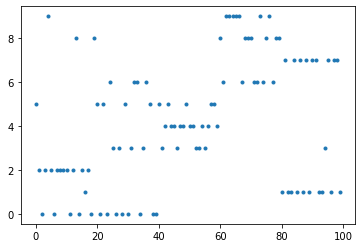

In [642]:
import leidenalg as la
import igraph as ig

h = ig.Graph.from_networkx(dist_graph_bin)
# h = ig.Graph.from_networkx(weight_graph)

cluster_membership = la.find_partition(h, la.ModularityVertexPartition)
## Equivalent to above
# cluster_membership = la.find_partition(h, la.RBConfigurationVertexPartition, 
#                                        resolution_parameter = 1.0
#                                       );

# cluster_membership = la.find_partition(h, la.RBConfigurationVertexPartition, 
#                                        resolution_parameter = 0.1
#                                       );

# cluster_membership = la.find_partition(h, la.CPMVertexPartition, 
#                                        resolution_parameter = 0.005);



# cluster_membership = la.find_partition(h, la.RBERVertexPartition, 
#                                        resolution_parameter = .0005);

# cluster_membership = la.find_partition(h, la.SignificanceVertexPartition);

# cluster_membership = la.find_partition(h, la.SurpriseVertexPartition);



item_labels = cluster_membership._membership
# indices, item_labels = np.array([(key, cluster_membership[key]) for key in cluster_membership]).T
# print(np.all(np.diff(indices) > 0))
plt.plot(item_labels, '.')

In [ ]:
import copy

def consolidate_list(arr, max_iter=10):
    """
    If an element intersects with any other element, replace
    that element with its union
    """
    is_changing = True
    iter_val = 0
    while is_changing and (iter_val < max_iter):
        
        arr_out = list()
        print(f"refinement {iter_val}")
        is_changing = False
        iter_val += 1
        for i, item1 in enumerate(arr):
            item_additional = list()
            for item2 in arr:
                if len(item1) == len(item2):
                    if np.allclose(item1, item2): 
                        continue
                if len(np.intersect1d(item1, item2)) > 0:
                    item_additional.append(copy.deepcopy(item2))
                    is_changing = True
            out_val = np.unique(np.hstack([copy.deepcopy(item1)] + item_additional))
    #         out_val = np.unique(np.hstack(item_additional))
    #         out_val = np.unique(copy.deepcopy(item1))

            arr_out.append(out_val)

            if i % 100 == 0:
                print(i)
        
        arr = arr_out
        
            
    return arr_out